<a href="https://colab.research.google.com/github/harshvs4/CIFAR100/blob/main/Dilated_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%matplotlib inline
import albumentations as A
import torch
import torchvision
import torchvision.transforms as transforms

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
print(trainset.data.mean(axis=(0,1,2))/255)
print(trainset.data.std(axis=(0,1,2))/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


horse plane  bird plane


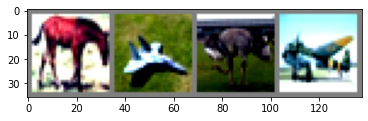

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=0,dilation=2,bias = False),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.03),

            nn.Conv2d(16, 16, 3, padding=0,dilation=2,bias = False), # 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.03),

            nn.Conv2d(16, 32, 3,  padding=0,dilation=2,bias = False), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.03),
        
        )

        self.trans1 = nn.Sequential(
            nn.Conv2d(32, 16, 1, dilation=2), # 22x22 output - 11x11 RF 14x14
            nn.ReLU(),
        )

        self.conv2 =  nn.Sequential(

            nn.Conv2d(16, 16, 3,  padding=0,dilation=2, bias = False), # 11x11 output - 9x9 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.03),

            nn.Conv2d(16, 32, 3,  padding=0,dilation=2,bias = False),  # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.03),
            
        )

        self.trans2 = nn.Sequential(

            nn.Conv2d(32, 16, 1,  dilation=2), # 9x9 output - 7x7 RF 18x18
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,  padding=0,dilation=2,bias = False), # 7x7 output - 5x5 RF 20x20
            nn.Conv2d(16, 10, 1)
        )

        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)

        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             432
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
         Dropout2d-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 20, 20]           4,608
             ReLU-10           [-1, 32, 20, 20]               0
      BatchNorm2d-11           [-1, 32, 20, 20]              64
        Dropout2d-12           [-1, 32, 20, 20]               0
    

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)

cuda


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.135
[1,  4000] loss: 1.921
[1,  6000] loss: 1.809
[1,  8000] loss: 1.756
[1, 10000] loss: 1.698
[1, 12000] loss: 1.661
[2,  2000] loss: 1.619
[2,  4000] loss: 1.582
[2,  6000] loss: 1.572
[2,  8000] loss: 1.557
[2, 10000] loss: 1.538
[2, 12000] loss: 1.502
Finished Training


GroundTruth:    cat  ship  ship plane


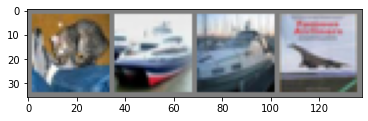

In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
outputs = net(images.to(device))

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  bird horse plane


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 62 %
Accuracy of  bird : 42 %
Accuracy of   cat : 18 %
Accuracy of  deer : 15 %
Accuracy of   dog : 30 %
Accuracy of  frog : 66 %
Accuracy of horse : 62 %
Accuracy of  ship : 60 %
Accuracy of truck : 56 %
